Authored by: Aryan Mistry, Harish Kashyap

# Sampling and Generative Models: From MCMC to Transformers

This notebook explores a range of generative modelling techniques. We start with **Markov Chain Monte Carlo (MCMC)** sampling, move on to the mechanics of **self‑attention**, provide an overview and code skeleton for **Generative Adversarial Networks (GANs)**, and conclude with **Transformers** for text generation. Each section includes exercises to deepen your understanding. [8][1][6]

### Introduction: Why Sampling?

Sampling is the process of drawing random examples from a probability distribution. Imagine rolling a six-sided die: each face has a fixed chance of landing face up. By sampling repeatedly from the die, you learn about its distribution and can estimate probabilities (e.g. one sixth for each face).

In machine learning, **generative models** assign probabilities to data and can produce new examples. Language models, for instance, assign high probability to fluent sentences and low probability to random gibberish. To turn those probabilities into actual sentences, we need to *sample* from the model: we draw words according to their probabilities so that the generated text follows the same patterns as the training data.

Sampling also underlies algorithms that draw samples from complex distributions when we cannot sample directly. Throughout this notebook we'll build intuition for why sampling is necessary and how various generative techniques—from simple random walks to Transformers—use sampling at their core.

First, we'll revisit the difference between **generative** and **discriminative** models:

- *Generative models* learn the joint distribution of inputs (and optionally labels) and can generate new data; examples include GPT-style language models, diffusion models and GANs.
- *Discriminative models* learn to predict labels given inputs (e.g. classify images or spam emails) but cannot easily generate new examples.

We'll start with a classic sampling algorithm called **Metropolis-Hastings** and progressively build up to modern architectures. [8][6][1]

### A Primer on Probability Distributions

At the heart of sampling is the notion of a **probability distribution**—a function that describes how likely different outcomes are. For a die, the distribution is uniform; for heights of people, it might look like a bell curve. Complex data often require more complicated distributions (e.g. a mixture of bell curves).

When sampling, we transform this abstract function into tangible examples. If the distribution assigns high probability density to values around 0 and low density elsewhere, a sampler should produce many samples near 0 and few outliers. In the following sections we'll see how to sample from such distributions without having to compute every probability exactly.

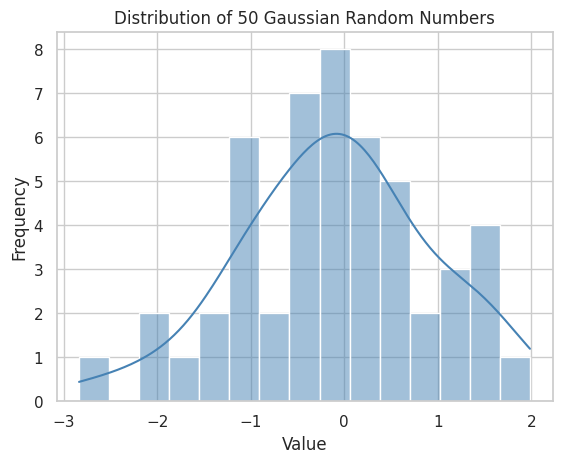

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# your Gaussian data
data = [
    -0.9577661001412319, -0.4283307748166502, -0.04030553439141707, -1.5943170705837773,
    -1.0159733128077597, 0.6957372818951008, -1.0260310371984076, -0.820559564195592,
    -0.5172811146753293, -0.3962797375742517, -0.395802462815595, 0.8658516143432616,
    0.3189513719672898, 1.409678839914139, -0.1153248519765555, -0.8509345208829596,
    -0.21843569625026016, -1.9703197897741416, 0.04453318208434268, -1.3175993839249014,
    -1.4042690072882922, 1.5699317111842788, 0.5654471920835286, 0.48106409361899516,
    1.9857757989306475, 0.42530349664239536, -1.0033009631977594, -2.182276945653412,
    -2.835821292311915, 0.3636018967082393, 0.04056661222933588, 0.7524172884500278,
    -0.17572541827966623, -0.14793313849524664, -0.4123475120076213, 0.45462666648229966,
    1.2464662221257177, 0.04470053341866886, -0.9836563966403988, -0.45057297568986504,
    1.3959521866470215, 1.618341793785497, 1.1595622112578092, 0.08715660863273379,
    0.06983491307216484, 0.20755500901870352, 0.20474729082380907, -0.3167794514615407,
    1.3347791157010636, -0.9487479897437666
]

# Seaborn histogram with KDE (Gaussian fit)
sns.set(style="whitegrid")
sns.histplot(data, kde=True, bins=15, color="steelblue")

plt.title("Distribution of 50 Gaussian Random Numbers")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


## How do we do the inverse? Get the values from the distribution?
### 1 – Metropolis–Hastings Sampling

> Add blockquote



The Metropolis–Hastings algorithm is a general MCMC method for drawing samples from a target distribution \(p(x)\) when direct sampling is difficult. It works by constructing a Markov chain whose stationary distribution is \(p(x)\). At each step we propose a new state from a proposal distribution \(q(x' \mid x)\) and accept or reject the proposal based on the ratio of target densities.

In this example we sample from a one‑dimensional mixture of Gaussians. [8]

### Metropolis-Hastings Sampling Explained

The **Metropolis-Hastings algorithm** is a workhorse of Monte-Carlo methods. It allows us to draw samples from complicated probability distributions—even when we cannot compute a normalised probability for every point.

Here's the intuition:

1. **Start at a point** in your space (e.g. x=0).
2. **Propose a nearby point** by adding a random "jitter" drawn from a simple distribution (e.g. a normal with standard deviation `proposal_std`).
3. **Compute how likely** the proposed point is relative to your current point by taking the ratio `target_density(proposal) / target_density(current)`. If this ratio is greater than 1, the proposed point lies in a region of higher probability.
4. **Decide to accept or reject:** flip a biased coin with probability equal to the ratio. If the coin comes up heads, move to the proposed point; otherwise stay where you are.
5. **Repeat** many times, building a chain of accepted points.

This simple accept–reject mechanism ensures that over time the algorithm spends more time in regions where the density is high (like the peaks of a bell curve) and less time in low-density regions. In the limit, the samples follow the target distribution.

**Mixture of Gaussians:** In the accompanying code we use a *mixture of Gaussians* as the target density. Imagine two overlapping bell curves—one centred at x=-2 with a narrow width, and another centred at x=1 with a wider width. The sampling algorithm must learn to visit both peaks in proportion to their relative heights.

If the math feels heavy, focus on the accept/reject intuition: *propose a move, favour moves to more probable regions, occasionally accept moves to less probable regions so you can explore the whole space*. [8]

Acceptance rate: 0.76


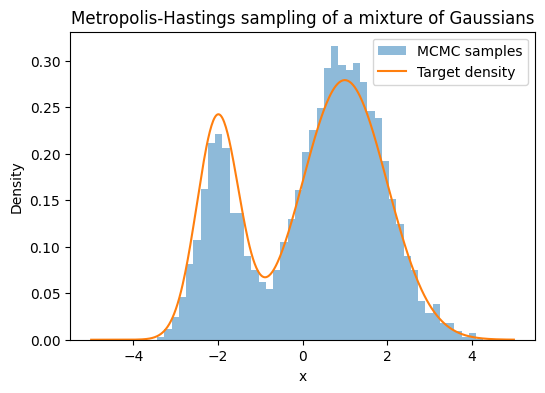

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi


def target_density(x):
    """
    Unnormalised density of a mixture of two Gaussian distributions.
    The first component has mean -2, standard deviation 0.5 and weight 0.3.
    The second component has mean +1, standard deviation 1.0 and weight 0.7.
    """
    comp1 = 0.3 * np.exp(-0.5 * ((x + 2) / 0.5)**2) / (0.5 * sqrt(2*pi))
    comp2 = 0.7 * np.exp(-0.5 * ((x - 1) / 1.0)**2) / (1.0 * sqrt(2*pi))
    return comp1 + comp2


def metropolis_hastings(n_samples: int = 5000, proposal_std: float = 1.0, init: float = 0.0):
    """
    Run a Metropolis-Hastings sampler for a 1D distribution.

    Parameters
    ----------
    n_samples : int
        Number of samples to draw.
    proposal_std : float
        Standard deviation of the Gaussian proposal distribution.
    init : float
        Starting point for the chain.

    Returns
    -------
    samples : np.ndarray
        Array of shape (n_samples,) containing the Markov chain.
    acceptance_rate : float
        The fraction of proposed moves that were accepted.
    """
    samples = np.zeros(n_samples)
    current = init
    accepted = 0
    for i in range(n_samples):
        proposal = current + np.random.normal(scale=proposal_std)
        # Calculate acceptance ratio
        accept_ratio = target_density(proposal) / target_density(current)
        # Accept with probability min(1, accept_ratio)
        if np.random.rand() < min(1, accept_ratio):
            current = proposal
            accepted += 1
        samples[i] = current
    acceptance_rate = accepted / n_samples
    return samples, acceptance_rate

# Run the sampler
samples, acc_rate = metropolis_hastings(n_samples=20000, proposal_std=0.8)
print(f'Acceptance rate: {acc_rate:.2f}')

# Discard the first 10% of samples as burn-in
burn_in = int(len(samples) * 0.1)
samples_burned = samples[burn_in:]

# Plot histogram of samples vs the true density
x = np.linspace(-5, 5, 500)
plt.figure(figsize=(6, 4))
plt.hist(samples_burned, bins=50, density=True, alpha=0.5, label='MCMC samples')
plt.plot(x, [target_density(t) for t in x], label='Target density')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Metropolis-Hastings sampling of a mixture of Gaussians')
plt.legend();
plt.show()


### MCMC Exercises

1. **Acceptance Rate:** Modify the `proposal_std` argument in `metropolis_hastings` and observe how the acceptance rate and the quality of the histogram change. Try values 0.1, 1.0 and 2.0. Which setting produces better mixing?
2. **Trace Plot:** Plot the trace of the sampled chain (values vs iteration) for 5,000 samples. Does the chain explore both modes?
3. **Mean and Variance:** Compute the empirical mean and variance of the samples and compare them to the theoretical values of the mixture distribution.
4. **Alternative Target:** Replace the mixture of Gaussians with another target distribution (e.g. a Beta distribution on [0,1] or a heavier‑tailed Student‑t distribution) and adapt the proposal accordingly.
5. **Autocorrelation:** Estimate the autocorrelation of the chain for different lags. How does it depend on the proposal standard deviation?


## 2 – Attention Mechanism

Self-attention allows a neural network to weigh the relevance of different positions within a sequence when computing representations. Imagine reading a sentence: when you process a word you don't treat every previous word equally—some words carry more context than others. Attention implements this intuition by learning *weights* that tell the model which tokens to "look at" when processing a given token.

The most common form of self-attention is called **scaled dot-product attention**. It takes three matrices:

- **Queries (Q):** vectors representing the item we're currently processing.
- **Keys (K):** vectors representing potential contexts.
- **Values (V):** vectors containing the information to be aggregated.

For each query, we compute how similar it is to each key (a dot product) to obtain a set of scores. We divide by the square root of the key dimension (to stabilise gradients) and pass the scores through a `softmax` to convert them into weights that sum to one. Finally we form a weighted sum of the values.

Mathematically:

$$\mathrm{Attention}(Q,K,V) = \mathrm{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}
\right)V$$

The key idea is that attention learns to assign bigger weights to the positions that matter most. [1]

### Understanding Attention Mechanisms

An **attention mechanism** allows a model to focus on the most relevant parts of its input when producing an output. Rather than compress an entire sentence into one fixed vector, attention assigns weights to each position, letting the model attend to different parts of the sequence as needed.

To compute attention:

1. Represent each word (or token) in the sequence with a **query**, **key** and **value** vector.
2. Measure how closely the query matches each key. These similarity scores determine how much attention to pay to each position.
3. Convert the scores to probabilities using the softmax function so they sum to one.
4. Compute a weighted sum of the values according to these probabilities—this is the "attended" representation.

This process repeats for each position in the sequence. In practice, attention lets a model learn alignments between languages in translation, capture long-range dependencies in text, and is the core of the transformer architecture. [1]

In [ ]:
import numpy as np

# Define toy query, key, and value tensors (batch_size=2, seq_len=3, d_model=4)
queries = np.array([[[1, 0, 1, 0], [0, 1, 0, 1], [1, 1, 0, 0]],
                    [[0, 1, 1, 0], [1, 0, 0, 1], [0, 0, 1, 1]]], dtype=float)
keys    = np.array([[[1, 0, 1, 0], [1, 1, 0, 0], [0, 1, 0, 1]],
                    [[0, 1, 1, 0], [0, 0, 1, 1], [1, 0, 0, 1]]], dtype=float)
values  = np.array([[[1, 0, 0, 1], [0, 1, 1, 0], [1, 1, 0, 0]],
                    [[0, 1, 0, 1], [1, 0, 1, 0], [0, 0, 1, 1]]], dtype=float)

def scaled_dot_product_attention(q, k, v):
    """
    Compute scaled dot-product attention for a batch of queries, keys and values.

    Parameters
    ----------
    q, k, v : np.ndarray
        Arrays of shape (batch_size, seq_len, d_model).

    Returns
    -------
    output : np.ndarray
        Attention-weighted representations, shape (batch_size, seq_len, d_model).
    weights : np.ndarray
        Attention weights for each query over keys, shape (batch_size, seq_len, seq_len).
    """
    dk = q.shape[-1]
    # Compute raw attention scores (batch, seq, seq)
    scores = np.matmul(q, k.transpose(0, 2, 1)) / np.sqrt(dk)
    # Softmax over keys dimension to obtain weights
    weights = np.exp(scores)
    weights /= weights.sum(axis=-1, keepdims=True)
    # Weighted sum of values
    output = np.matmul(weights, v)
    return output, weights

attn_output, attn_weights = scaled_dot_product_attention(queries, keys, values)

print('Attention weights for the first sequence (rows sum to 1):')
print(attn_weights[0])
print('Attention output vectors for the first sequence:')
print(attn_output[0])


Attention weights for the first sequence (rows sum to 1):
[[0.50648039 0.30719589 0.18632372]
 [0.18632372 0.30719589 0.50648039]
 [0.27406862 0.45186276 0.27406862]]
Attention output vectors for the first sequence:
[[0.69280411 0.49351961 0.30719589 0.50648039]
 [0.69280411 0.81367628 0.30719589 0.18632372]
 [0.54813724 0.72593138 0.45186276 0.27406862]]


The first matrix printed above shows the **attention weights** for the first batch: each row corresponds to a query position, and the columns correspond to the keys in the sequence. The rows sum to 1 because they are probabilities. Notice how the model pays different amounts of attention to each position.

The second matrix shows the **attended vectors**, which are weighted sums of the value vectors. Experiment by creating your own `queries`, `keys` and `values` arrays to see how changing them affects the weights and outputs.

### Attention Exercises

1. **Custom Input:** Create your own small query, key and value matrices (e.g. with shape `(1,4,2)`) and compute the attention weights. How do the weights change when the query matches only some keys?
2. **Visualising Weights:** For a longer toy sequence, visualise the attention weights as a heatmap using Matplotlib. What patterns do you see?


## 3 – Generative Adversarial Networks (GANs)

![GAN](/content/drive/sample_data/GAN.png)


A **Generative Adversarial Network (GAN)** is like a game between a forger and a detective. The **generator** (forger) tries to produce realistic data samples from random noise, while the **discriminator** (detective) tries to tell the real samples apart from the fakes. They train together in a minimax game: the generator improves to fool the discriminator, and the discriminator improves to catch the generator. When they reach equilibrium, the generator's outputs become difficult to distinguish from real data.

Below is skeleton code for a simple GAN in PyTorch that learns to generate 2-D points. It won't run in this environment because the necessary libraries are not installed, but it serves as a template for your own experiments. [6]



### Why GANs Use Sampling

During GAN training the generator learns to transform samples from a simple noise distribution (e.g. uniform or normal) into synthetic data. This sampling step is essential: it allows the generator to explore the space of possible outputs and gradually adapt them to match the true data distribution. Meanwhile the discriminator learns from both real samples (drawn from the training data) and fake samples (generated by the sampler). In essence, GANs leverage sampling twice: to produce training examples for the discriminator and to map random noise into structured outputs. [6]

In [ ]:
# Skeleton GAN implementation
# This code uses PyTorch to define a generator and a discriminator that operate on 2-D data.

# import torch
# import torch.nn as nn
# import torch.optim as optim

# class Generator(nn.Module):
#     def __init__(self, noise_dim=2, hidden_dim=16, data_dim=2):
#         super().__init__()
#         # A simple feed-forward network that maps random noise to data space.
#         self.net = nn.Sequential(
#             nn.Linear(noise_dim, hidden_dim), nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
#             nn.Linear(hidden_dim, data_dim)
#         )
#     def forward(self, z):
#         return self.net(z)

# class Discriminator(nn.Module):
#     def __init__(self, data_dim=2, hidden_dim=16):
#         super().__init__()
#         # Maps data points to a single probability (real vs fake).
#         self.net = nn.Sequential(
#             nn.Linear(data_dim, hidden_dim), nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
#             nn.Linear(hidden_dim, 1), nn.Sigmoid()
#         )
#     def forward(self, x):
#         return self.net(x)

# # Training loop (pseudocode)
# G = Generator()
# D = Discriminator()
# g_opt = optim.Adam(G.parameters(), lr=1e-3)
# d_opt = optim.Adam(D.parameters(), lr=1e-3)
# for epoch in range(num_epochs):
#     for real_batch in data_loader:
#         # Sample random noise for generator input
#         z = torch.randn(batch_size, noise_dim)
#         fake_batch = G(z).detach()  # Generate fake data
#         # Discriminator loss: maximise log(D(real)) + log(1 - D(fake))
#         d_loss = -torch.mean(torch.log(D(real_batch)) + torch.log(1 - D(fake_batch)))
#         d_opt.zero_grad(); d_loss.backward(); d_opt.step()
#         # Generator loss: maximise log(D(fake))
#         z = torch.randn(batch_size, noise_dim)
#         fake_batch = G(z)
#         g_loss = -torch.mean(torch.log(D(fake_batch)))
#         g_opt.zero_grad(); g_loss.backward(); g_opt.step()
# print('GAN training complete')


## 4 – Transformers for Text Generation

Transformers have revolutionised natural language processing by relying entirely on attention mechanisms to model relationships within sequences. Pre-trained transformer models, such as GPT-2, can generate coherent and contextually relevant text given a prompt. They work by predicting one token at a time and using self-attention to incorporate context from previous tokens. We'll briefly sketch how they generate text. [1]

### Why Sampling Matters for Transformers

Transformers produce, at each step, a **probability distribution** over the vocabulary for the next word. To turn this distribution into an actual word, we sample from it. Two common strategies:

- **Greedy decoding:** always pick the most likely word. This can be deterministic but may lead to repetitive or boring text.
- **Sampling with temperature:** draw a word at random according to its probability; a *temperature* parameter `T` rescales the probabilities (`p_i ∝ p_i**(1/T)`), controlling the trade-off between exploring diverse words (`T > 1`) and sticking to high-probability words (`T < 1`).

We can also restrict the sampling to a subset of likely words (e.g. top-k or nucleus sampling) to avoid extremely unlikely words. By repeatedly predicting and sampling the next token, a transformer can generate sentences and paragraphs conditioned on the prompt. [1]

In [ ]:
# Example usage of Hugging Face transformers for text generation
# This example will not run here, but illustrates how to load a model and generate text.
# !pip install transformers torch
# from transformers import pipeline
# generator = pipeline('text-generation', model='gpt2')
# prompt = 'The future of artificial intelligence is'
# outputs = generator(prompt,
#                     max_length=40,
#                     num_return_sequences=3,
#                     do_sample=True,    # set to False for greedy decoding
#                     temperature=0.8,   # control randomness
#                     top_k=50)          # restrict sampling to top 50 tokens
# for i, out in enumerate(outputs, 1):
#     print(f'Output {i}:', out['generated_text'])


### Transformer Exercises

1. **Install and Run:** On your own machine, install the `transformers` library and run the code above. Try different prompts and observe how the generated content varies.
2. **Model Selection:** Replace `gpt2` with `distilgpt2` or a multilingual model such as `facebook/xlm-roberta-base`. How do the outputs differ?
3. **Generation Parameters:** Experiment with `max_length`, `temperature`, `top_k` and `top_p` parameters. How do they influence creativity and coherence?


Foundational LLMs & Transformers
1. Vaswani, A., et al. (2017). Attention is All You Need. Advances in Neural Information Processing Systems (NIPS 2017).
2. Brown, T. B., et al. (2020). Language Models are Few-Shot Learners. NeurIPS 2020.
3. Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. NAACL-HLT 2019.
4. OpenAI (2023). GPT-4 Technical Report. arXiv:2303.08774.
5. Touvron, H., et al. (2023). LLaMA 2: Open Foundation and Fine-Tuned Chat Models. Meta AI.

Generative AI & Sampling

6. Goodfellow, I., et al. (2014). Generative Adversarial Nets. NeurIPS 2014.
7. Bishop, C. M. (2006). Pattern Recognition and Machine Learning. Springer.
8. Neal, R. M. (1993). Probabilistic Inference Using Markov Chain Monte Carlo Methods. Technical Report CRG-TR-93-1, University of Toronto.

Retrieval-Augmented Generation (RAG) & Knowledge Grounding

9. Lewis, P., et al. (2020). Retrieval-Augmented Generation for Knowledge-Intensive NLP. NeurIPS 2020.
10. deepset ai (2023). Haystack: Open-Source Framework for Search and RAG Applications. https://haystack.deepset.ai
11. LangChain (2023). LangChain Documentation and Cookbook. https://python.langchain.com

Evaluation & Safety

12. Papineni, K., et al. (2002). BLEU: A Method for Automatic Evaluation of Machine Translation. ACL 2002.
13. Lin, C.-Y. (2004). ROUGE: A Package for Automatic Evaluation of Summaries. ACL Workshop 2004.
14. OpenAI (2024). Evaluating Model Outputs: Faithfulness and Grounding. OpenAI Docs.
15. Guardrails AI (2024). Open-Source Guardrails Framework. https://github.com/shreyar/guardrails

Prompt Engineering & Instruction Tuning

16. White, J. (2023). The Prompting Guide. https://www.promptingguide.ai
17. Ouyang, L., et al. (2022). Training Language Models to Follow Instructions with Human Feedback. NeurIPS 2022.

Agents & Tool Use

18. Yao, S., et al. (2022). ReAct: Synergizing Reasoning and Acting in Language Models. arXiv:2210.03629.
19. LangChain (2024). LangChain Agents and Tools Documentation.
20. Microsoft (2023). Semantic Kernel Developer Guide. https://learn.microsoft.com/en-us/semantic-kernel/
21. Google DeepMind (2024). Gemini Technical Report. arXiv:2312.11805.

State, Memory & Orchestration

22. LangGraph (2024). Stateful Agent Orchestration Framework. https://langchain-langgraph.vercel.app
23. Park, J. S., et al. (2023). Generative Agents: Interactive Simulacra of Human Behavior. arXiv:2304.03442.

Pedagogical and Course Design References

24. fast.ai (2023). fast.ai Deep Learning Course Notebooks. https://course.fast.ai
25. Ng, A. (2023). DeepLearning.AI Short Courses on Generative AI.
26. MIT 6.S191, Stanford CS324, UC Berkeley CS294-158. (2022–2024). Course Materials and Public Notebooks for ML and LLMs.